In [1]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt

In [10]:
def mass_weight(w, err):
    mass = w.sum('z')
    mw =  (w * err).sum('z')/mass
    return mw.median('seed').mean('y')


def get_data(path="../data/output/test_error.nc"):
    errors = xr.open_dataset(path)
    
    ds = xr.Dataset(dict(
        mqt = mass_weight(errors.w, errors.qt),
        msl = mass_weight(errors.w, errors.sl),
        train=errors.train_loss,
        nhidden=errors.nhidden.isel(seed=0),
        window_size=errors.window_size.isel(seed=0),

    ))

    return ds.to_dataframe().reset_index()


def plot_error_series(x, y, hue, data, ax=None, **kwargs):
    
    if not ax:
        ax = plt.gca()
    
    lines = []
    ns = []
    for n, val in data.groupby(hue):
        val = val.groupby(x).min().reset_index()
        val = val.sort_values(x)
        line, = ax.plot(val[x], val[y], label=n, **kwargs)
        lines.append(line)
        ns.append(n)
    return ns, lines


def plot_parameter_experiments(y, df, ax=None):
    if not ax:
        ax = plt.gca()
        
    ax.set_prop_cycle(plt.cycler('alpha', [.2, .4, .6, .8, 1.0]))

    t, wind = plot_error_series("epoch", y, "nhidden",
                      df[(df.window_size == 10) & (df.epoch >= 1)],
                      marker='s', color='k', ax=ax)

    n, nhid = plot_error_series("epoch", y, "window_size",
                      df[(df.nhidden == 128) & (df.epoch >= 1) & (df.window_size > 2)],
                      marker='s', color='r', ax=ax)
    
    return t, wind, n, nhid


def add_legend(args, ax, kw1={}, kw2={}):
    t, wind, n, nhid = args
    leg1 = plt.legend(wind, t, title='Number Hidden', **kw1)
    ax.add_artist(leg1)
    leg2 = plt.legend(nhid, n, title='Window Size', **kw2)
    
    
def adjust_spines(ax):
    for spine in ['right', 'top']:
        ax.spines[spine].set_color('none')
        

def combined_plots(df):

    fig, axs = plt.subplots(1, 3, figsize=(6.0, 2.5), constrained_layout=True)



    plot_parameter_experiments("train", df, ax=axs[0])
    axs[0].set_title("A) Training Loss", loc="left")

    plot_parameter_experiments("mqt", df, ax=axs[1])
    axs[1].set_title("B) Test error ($q_T$)", loc="left")

    args = plot_parameter_experiments("msl", df, ax=axs[2])
    axs[2].set_title("B) Test error ($s_L$)", loc="left")



    for ax in axs:
        adjust_spines(ax)


    for ax in axs:
        ax.set_xticks(np.arange(1, 6))


    loc = (1.0, .5)
    add_legend(args, ax=axs[2],
               kw1=dict(loc="lower left", bbox_to_anchor=loc, frameon=False, ),
               kw2=dict(loc="upper left", bbox_to_anchor=loc, frameon=False))
    
    
def main(path):
    """main plotting routine
    
    Parameters:
    -----------
    path : str
         path to test_error.nc
         
    """
    df = get_data(path)
    combined_plots(df)

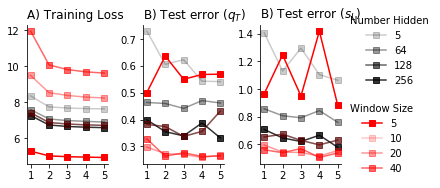

In [11]:
main("../data/output/test_error.nc")